# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Четвертая лабораторная работа </center>
# <center> Акустические признаки </center>

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn

%matplotlib inline

In [2]:
# Функция отрисовки аудио сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

In [3]:
# Для выполнения задания нам понадобится датасет yes/no. 
# Про датасет можно почитать тут https://www.openslr.org/1/

# Скачаем его
![ ! -f  waves_yesno.tar.gz ] && wget https://www.openslr.org/resources/1/waves_yesno.tar.gz
# И распакуем
!tar -xvzf waves_yesno.tar.gz

# P.S если у вас Windows, или по каким-либо еще причинам данные не скачались, 
# то их можно скачать руками отсюда: https://www.openslr.org/1/

--2021-03-16 11:25:04--  https://www.openslr.org/resources/1/waves_yesno.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4703754 (4.5M) [application/x-gzip]
Saving to: ‘waves_yesno.tar.gz’

waves_yesno.tar.gz  100%[===================>]   4.49M  --.-KB/s    in 0.1s    

2021-03-16 11:25:06 (36.2 MB/s) - ‘waves_yesno.tar.gz’ saved [4703754/4703754]

waves_yesno/
waves_yesno/1_0_0_0_0_0_1_1.wav
waves_yesno/1_1_0_0_1_0_1_0.wav
waves_yesno/1_0_1_1_1_1_0_1.wav
waves_yesno/1_1_1_1_0_1_0_0.wav
waves_yesno/0_0_1_1_1_0_0_0.wav
waves_yesno/0_1_1_1_1_1_1_1.wav
waves_yesno/0_1_0_1_1_1_0_0.wav
waves_yesno/1_0_1_1_1_0_1_0.wav
waves_yesno/1_0_0_1_0_1_1_1.wav
waves_yesno/0_0_1_0_1_0_0_0.wav
waves_yesno/0_1_0_1_1_0_1_0.wav
waves_yesno/0_0_1_1_0_1_1_0.wav
waves_yesno/1_0_0_0_1_0_0_1.wav
waves_yesno/1_1_0_1_1_1_1_0.wav
waves_yesno/0_0_1_1_1_1_0_0.wav


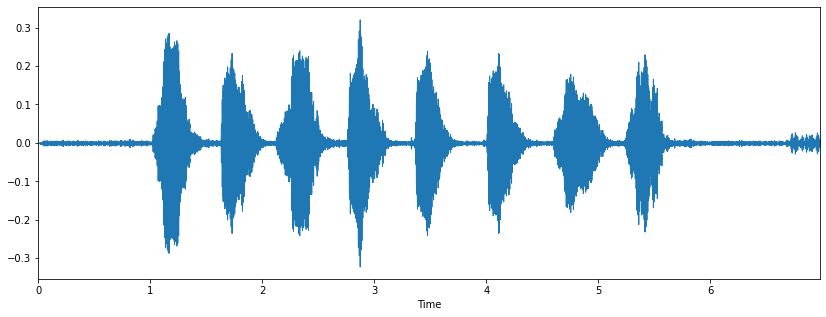

In [4]:
# Загрузим один из файлов
wav, sr = librosa.load("waves_yesno/0_1_0_1_1_1_0_0.wav")
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

Как можно услышать, в этом датасете произносятся какие-то два слова (yes/no на иврите). Каждый файл состоит из 8 произнесений. Метки слов указаны в названиях файлов.

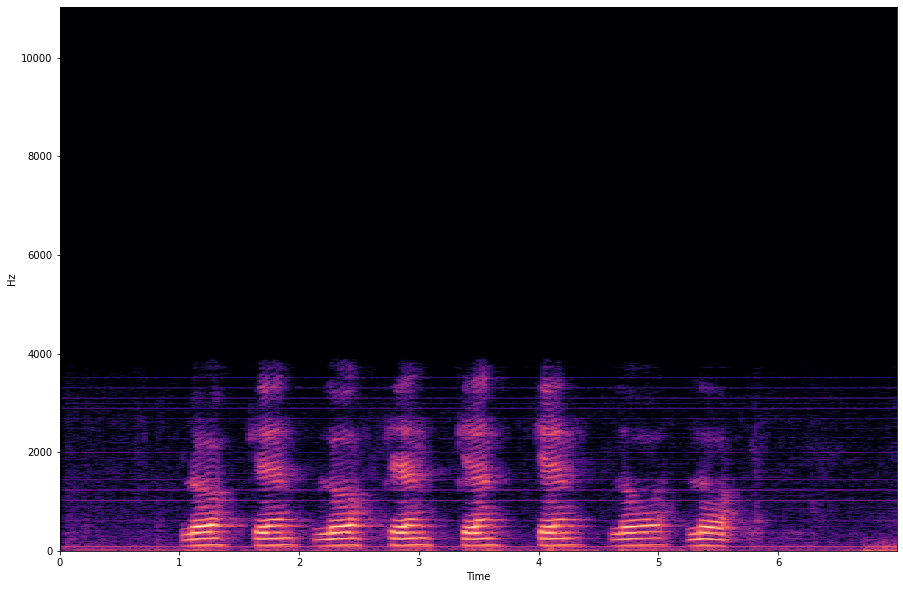

In [5]:
# Построим спектрограмму загруженной вавки
stft = librosa.stft(wav)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')

# Задание 0.1: Анализ спектрограммы (0.5 балла)
1. Посмотрите на спектрограмму и попробуйте найти признаки, по которым можно отличить произнесение "yes" от "no". 
1. В каких частотах находится основная энергия этого речевого сигнала? 

**1**. Для слова can есть обрыв на частоте ~1000 Hz по сравнению с lo. Lo более вытянутый (плавный) звук, чем can, поэтому происходит этот резкий обрыв.

**2**. До 3000 Hz.

# Задание 1: Мел-шкала (1 балл)
Нарисовать спектрограму в [mel-шкале](https://en.wikipedia.org/wiki/Mel_scale). 
Использовать формулу, представленную Дугласом О'Шонесси.

In [9]:
def mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def hz(mel):
    return 700 * (10 ** (mel / 2595) - 1)

In [10]:
def test_mel():
    x = np.random.randint(100, size=(1000, 100))
    x_mel = mel(x)
    x_hz = 700.0 * (10.0 ** (x_mel / 2595.0) - 1.0)
    assert np.allclose(x, x_hz), "TEST Hertz -> Mel -> Hertz  failed. "
    print("Ok!")
test_mel() 

Ok!


# Мел-фильтры
Одними из наиболее популярных акустических признаков являются Filter Banks (fbanks). 
fbanks вычисляются применением нескольких (количество фильтров = количество fbanks) треугольных фильтров к мел-спектрограмме. Чтобы не делать два действия со спектрограммой, переход к мел-шкале и применение фильтров в мел-шкале можно заменить на перевод мел-фильтров в Герц-шкалу и применение их к Герц-спектрограмме.



# Задание 2 (3 балла)
Реализуйте функцию вычисления fbank. 

In [13]:
def mel_filters(
    sr: int,
    n_fft: int,
    n_mels: int
    ) -> np.array:

    # функция построения треугольных мел-фильтров в герц-шкале
    # sr - sample rate
    # n_fft - length of the FFT window 
    # n_mels - number of filters
    # return mel filters matrix. [n_mels, n_fft]

    n_fft_new, f_max = 1 + n_fft // 2, sr / 2

    fftfreqs = np.linspace(0, f_max, n_fft_new)
    mel_f = hz(np.linspace(mel(0), mel(f_max), n_mels + 2))

    fdiff = np.diff(mel_f)
    ramps = np.subtract.outer(mel_f, fftfreqs)

    result = np.array([
        np.maximum(0, np.minimum(-ramps[i] / fdiff[i], ramps[i + 2] / fdiff[i + 1]))
        for i in range(n_mels)
    ])

    enorm = 2.0 / (mel_f[2: n_mels + 2] - mel_f[:n_mels])
    result *= enorm[:, np.newaxis]

    return result

In [14]:
assert mel_filters(32, 46, 4).shape == (4, 24) and \
    mel_filters(65, 45, 5).shape == (5, 23), "Wrong shape"
assert np.allclose(mel_filters(16, 8, 4), librosa.filters.mel(16, 8, n_mels=4, htk=True))
assert np.allclose(mel_filters(8600, 512, 40), librosa.filters.mel(8600, 512, n_mels=40, htk=True))
print("All ok!")

All ok!


In [23]:
def get_fbanks(
    wav: np.ndarray,
    sr: int,
    window_ms: int=25,
    step_mc: int=10,
    n_fbanks: int=40
    ) -> np.array:
  
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_fbanks - number of filters
    # return fbank matrix [n_fbanks, time]

    n_fft, hop_length = window_ms * sr // 1000, step_mc * sr // 1000
    S = np.abs(librosa.stft(
        y = wav,
        n_fft = n_fft,
        hop_length = hop_length
    )) ** 2
    
    return mel_filters(sr, n_fft, n_fbanks) @ S

In [24]:
def test_fbank(wav, sr, window_ms=25, step_mc=10, n_fbanks=40):
    n_fft = window_ms * sr // 1000
    hop_length = step_mc * sr // 1000
    fbanks_lib = librosa.feature.melspectrogram(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_fbanks, htk=True)
    fbanks = get_fbanks(wav, sr, window_ms=window_ms, step_mc=step_mc, n_fbanks=n_fbanks)
    
    if fbanks_lib.shape != fbanks.shape:
        print("TEST FAILED")
        print(f"Shape {fbanks_lib.shape} != {fbanks.shape}")
    if not np.allclose(fbanks_lib, fbanks):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(fbanks_lib - fbanks))}")
        return -1
    print("TEST PASSED")
    return 0
    assert test_fbank(wav[:sr*1], sr) == 0, "1 sec wav test failed"
    assert test_fbank(wav, sr) == 0 , "All wav test failed"
    print("All ok!")
test_fbank(wav, sr, window_ms=25, step_mc=10, n_fbanks=40)

TEST PASSED


0

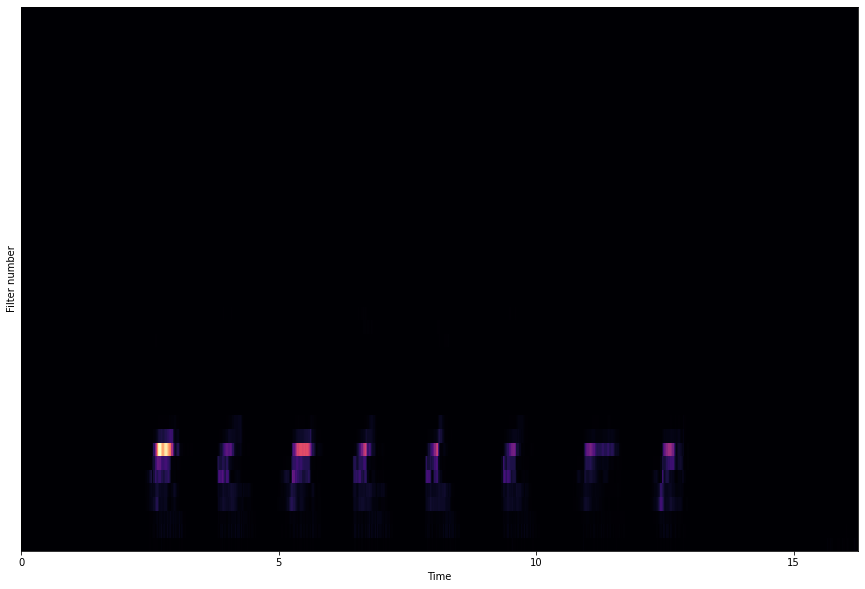

In [25]:
fbanks = get_fbanks(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(fbanks, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Задание 3 (3 балла)
Реализовать вычисление [mfcc](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)



In [34]:
def get_mfcc(
    wav: np.ndarray,
    sr: int,
    window_ms=25,
    step_mc=10,
    n_mfcc=13
    ) -> np.array:
    

In [35]:
def test_mfcc(wav, sr, window_ms=25, step_mc=10, n_mfcc=13):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    mfcc_lib = librosa.feature.mfcc(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc, n_mels=40, htk=True)
    mfcc = get_mfcc(wav, sr, window_ms=window_ms, step_mc=step_mc, n_mfcc=n_mfcc)
    
    if mfcc_lib.shape != mfcc.shape:
        print("TEST FAILED")
        print(f"Shape {mfcc_lib.shape} != {mfcc.shape}")
    if not np.allclose(mfcc_lib, mfcc, atol=1e-04):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(mfcc_lib - mfcc))}")
        return -1
    print("TEST PASSED")
    return 0
assert test_mfcc(wav[:sr*1], sr) == 0, "1 sec wav test failed"
assert test_mfcc(wav, sr) == 0 , "All wav test failed"
print("All ok!")

TEST FAILED
Average diff is 550.2130737304688


AssertionError: ignored

In [ ]:
mfcc = get_mfcc(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Классификация слов
Построим простую систему, классифицирующую слова yes/no.

Загрузим весь датасет

In [ ]:
def load_yn_dataset(directory):
    X, labels = [], []
    for f in glob(directory +"/*.wav"):
        name = os.path.basename(f)[:-4]
        y = [int(l) for l in name.split("_")]
        x, _ = librosa.load(f)
        X.append(x)
        labels.append(y)
        
    return X, labels
        
X, Y = load_yn_dataset("waves_yesno/")

Отделим 20% для теста

In [ ]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y,test_size=0.2, random_state=1)

# Задание *4 (1 балл)
Voice Activity Detector (VAD) определяет, есть ли речь в текущем кадре или нет.
Реализуйте простой VAD.
Настройте VAD, чтобы хорошо определялись границы слов.

In [ ]:
# YOUR CODE HERE

# train_VA = # np.ndarray. 1 - Voice, 0 - silence
# test_VA = # np.ndarray. 1 - Voice, 0 - silence
        
#
    

In [ ]:
def test_VAD(VA, Y):
    def check_diff(diff, num_words):
        if diff.sum()!=0:
            print("VAD detected speech at the beginning (or end) of audio")
            return -1 
        if not (diff > 0).sum() == (diff > 0).sum() ==  num_words:
            print("Wrong number of words. Each audio contains 8 words")
            return -2
        return 0
    
    for i, (va, y) in enumerate(zip(VA, Y)):
        diff = va[1:]  - va[:-1]
        assert check_diff(diff, len(y)) == 0, f"Bad {i} example"

test_VAD(train_VA, Y_train)
test_VAD(test_VA, Y_test)

# Задание *5 (2 балла)
Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усредненным признаки слов выделеных слов. Или любым другим удобным для вас способом. 